# Computational example 2: MAP estimation   

In [1]:
# To start this notebook with more than one thread run "export JULIA_NUM_THREADS=4" in the terminal 
# before starting the jupyter notebook

# Ensure that Julia was launched with an appropriate number of threads
println(Threads.nthreads())

1


In [2]:
# Import module. 
using Revise
using PriorNormalization

In [3]:
# Import packages 
using ApproxFun # for approximating gammainvccdf by a Chbychev interpolant to then use AD  
using CairoMakie # for plots 
using JLD2 # for saving and loading results
using LinearAlgebra # to represent the identity matrix as "I" 
using Random # for generating random noise 
using StatsBase # for defining customized distributions 
using StatsFuns # for defining customized distributions 
using StatsPlots # for plotting 
using SparseArrays # for efficient storing of the forward operator 
using SpecialFunctions
using Optim # for ML and MAP estimation 
using Plots: Plots, plot, plot!, scatter, scatter!, savefig, surface, surface!
using ProgressMeter # to show progress 

## Signal deblurring problem: Define the data model 

In [4]:
# Model parameters 
σ² = 0.03^2 # noise variance 
kernel_width = 0.02 # width of the Gaussian kernel
N_dense = 1_000 # number of points for the dense model
N_coarse = 128 # number of points for the coarse model
tt = [0.17, 0.39, 0.48, 0.73, 0.83] # Positions of the increments
dx = [1, -2.4, 2.8, -0.6, -0.8] # Values of the increments

5-element Vector{Float64}:
  1.0
 -2.4
  2.8
 -0.6
 -0.8

In [5]:
# Define the piecewise constant signal. 
function signal(t; tt=[0.17, 0.39, 0.48, 0.73, 0.83], 
    dx = [1, -2.4, 2.8, -0.6, -0.8])
    x = 0
    Ij = findall(x -> x < t, tt)
    if !isempty(Ij)
        x = sum(dx[Ij])
    end
    
    return x
end

signal (generic function with 1 method)

In [6]:
# Set up the dense data model  

# Generate the dense grid (we assume that the signal vanishes at t=0)
t_dense = (1:N_dense) / N_dense 

# Generate the dense forward operator 
S = reshape(repeat(t_dense, N_dense, 1), N_dense, N_dense)
T = S'
F_dense = (6.4/N_dense) * exp.(-1/(2*kernel_width^2) * (T.-S).^2) 

# Generate the dense step signal and observations 
x_dense = signal.(t_dense) # signal values 
y_dense = F_dense * x_dense # observations

1000-element Vector{Any}:
  3.74278937539227e-18
  5.744144243534786e-18
  8.79393927412621e-18
  1.3429811599511571e-17
  2.0459022030414613e-17
  3.1090554911693094e-17
  4.713037498942281e-17
  7.126926866908596e-17
  1.0750603997755944e-16
  1.6176805186960793e-16
  2.428187113838113e-16
  3.6358103971191115e-16
  5.430629429581705e-16
  ⋮
  2.653109939010615e-16
  1.693119370541826e-16
  1.0509846120628357e-16
  6.233097419208321e-17
  3.399747075949146e-17
  1.535468383152762e-17
  3.2021048354653674e-18
 -4.614439835542763e-18
 -9.541335133345305e-18
 -1.2547439067780209e-17
 -1.4280276203172293e-17
 -1.5171704985465577e-17

In [7]:
# Set up the coarse data model  

# Generate the dense grid (we assume that the signal vanishes at t=0)
t_coarse = (1:N_coarse) / N_coarse 

# Generate the dense forward operator 
S = reshape(repeat(t_coarse, N_coarse, 1), N_coarse, N_coarse)
T = S'
F_coarse = (6.4/N_coarse) * exp.(-1/(2*kernel_width^2) * (T.-S).^2) 

# Get the coarse grid and forward operator 
stride = 6 # use every stride-th point 
t_obs = t_coarse[1:stride:end]
F_coarse = F_coarse[1:stride:end, :]

# Find the nearest points in the dense grid
m = length(t_obs)
I_dense = zeros(Int, m)
for j in 1:m
    I_dense[j] = argmin(abs.(t_dense .- t_obs[j]))
end
     
# Coarse data with added noise
Random.seed!(123) # Setting the seed 
y_coarse = y_dense[I_dense] .+ sqrt(σ²)*randn(m)

22-element Vector{Float64}:
  0.024248637853949075
 -0.033662174013312236
 -0.0330405837932554
  0.029287043345179183
  0.2940981669227508
  0.327686874975743
  0.3081952099427758
  0.2777071046214233
  0.05048177801952833
 -0.42893921131588875
 -0.025823461324423404
  0.44289681623261085
  0.44824991807951886
  0.45866277848478854
  0.38423141555734325
  0.39076867021704076
  0.24027054143339752
  0.25185204966863195
  0.040533135900496814
  0.004545874644471382
  0.03028840373486345
  0.0008629990815682161

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


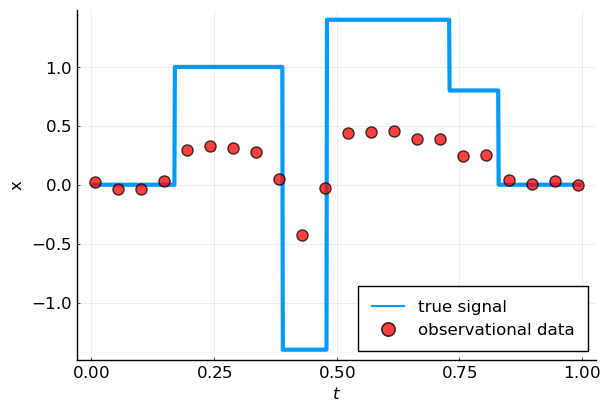

"/Users/janglaubitz/src/2024_priorNormalization_dev/PriorNormalization.jl/notebooks/figures/deblurring_data.pdf"

In [8]:
# create grid points and compute discrete signal values 
t_range_aux = range(0, stop=1, length=1000)
signal_values = signal.(t_range_aux)

pyplot() 
# Create the plot 
plot_signal = Plots.plot( 
    t_range_aux, signal_values; 
    label="true signal", lw=3, ls=:solid 
)
# Add noisy observational data  
Plots.scatter!(plot_signal, 
    t_obs, y_coarse; 
    label="observational data", 
    color = :red, markersize = 8, alpha = 0.75 
)
# Make some cosmetic changes to the plot 
Plots.plot!( plot_signal, 
    xlabel=L"t", ylabel="x", 
    tickfontsize=12, labelfontsize=12, legendfontsize=12, # font sizes 
    legend=:bottomright
)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(script_directory, "figures/deblurring_data.pdf")
savefig(output_filename)

In [9]:
# Invertible finite difference matrix
aux = ones(N_coarse) * [-1.0, 1.0]'
L = spzeros(Float64,N_coarse,N_coarse)
L[2:end,:] = spdiagm(0=>-1*ones(N_coarse), 1=>ones(N_coarse))[1:N_coarse-1,1:N_coarse]
L[1,1] = 1 

# Change coordinates to promot sparsity in z = Lx
FL = F_coarse / L # F_coarse * inv(L)

# Whitening
FL_w = (1/sqrt(σ²)) * FL
y_w = (1/sqrt(σ²)) * y_coarse

# Rename varables for simplicity 
F = FL_w 
y = y_w 
M, N = size(F)

(22, 128)

## Generic models for the original and prior-normalized problem

In [10]:
# Different parameters of  generalized gamma hyper-prior 
r_range = [ 1.0, .5, -.5, -1.0 ]; 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ];
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ];

In [11]:
# Define the log-posterior density 
function logpdf_original(θ, z; F, y, r, β, ϑ)    
    if any(θ .<= 0) # any non-positive element? 
        logpdf = -Inf 
    else
        logpdf = -0.5*norm(F*z-y)^2 - 
            0.5*sum( z.^2 ./ θ ) - 
            sum( (θ/ϑ).^r ) + 
            (r*β-1.5)*sum( log.(θ) )
    end
    
    return logpdf
end

logpdf_original (generic function with 1 method)

In [12]:
# Define the posterior density 
function logpdf_priorNormalized(τ, u; F, y, r, β, ϑ, Φ::Function) 
    
    # Get value of log-prior
    log_prior = -0.5*sum( u.^2 + τ.^2 )
    
    # Get z-value by using transport MAP 
    N = length(u)
    z = zeros(N)
    for n in 1:N
        z[n] = priorNormalizing_KR_inv_tu( u[n], τ[n]; r, β, ϑ, Φ )
    end
    
    # Get the log of the transformed likelihood 
    log_likelihood = -0.5*norm(F*z-y)^2

    # Get log-posterior 
    logpdf = log_prior + log_likelihood
    
    return logpdf
end

logpdf_priorNormalized (generic function with 1 method)

## MAP estimation for model with $r=1$

### Initiate the models

In [13]:
# Select hyper-hyper-parameters 
model_nr = 1 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [14]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation  
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success

 * Candidate solution
    Final objective value:     5.109389e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.12e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.24e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.42e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.78e-16 ≰ 0.0e+00
    |g(x)|                 = 8.80e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   118  (vs limit 600)
    Iterations:    13033
    f(x) calls:    44550
    ∇f(x) calls:   44550


In [15]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
z_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
x_MAP = L \ z_MAP

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_original.jld2" θ_MAP z_MAP x_MAP

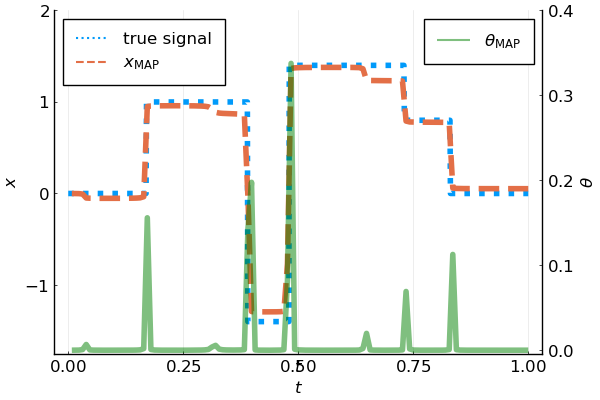

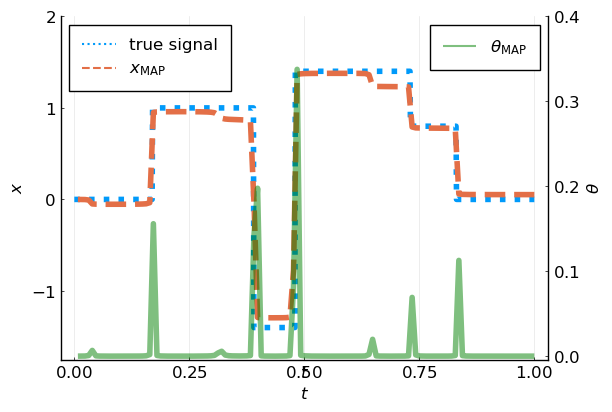

In [16]:
# Illustrate the MAP estimate of the target posterior
pyplot()
#gr()  # Switch to GR backend

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_MAP; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_MAP; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-4e-3, 0.4],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_original.pdf"
)
#PyPlot.savefig(output_filename)

### MAP estimate for the prior-normalized posterior

In [17]:
# Initial guess for the optimization (τ and u)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success

 * Candidate solution
    Final objective value:     1.696086e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.98e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.06e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.84e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   27  (vs limit 600)
    Iterations:    353
    f(x) calls:    1051
    ∇f(x) calls:   1051


In [18]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
u_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP u_MAP

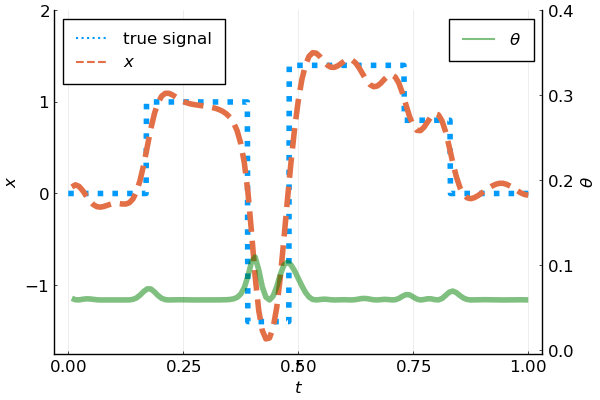

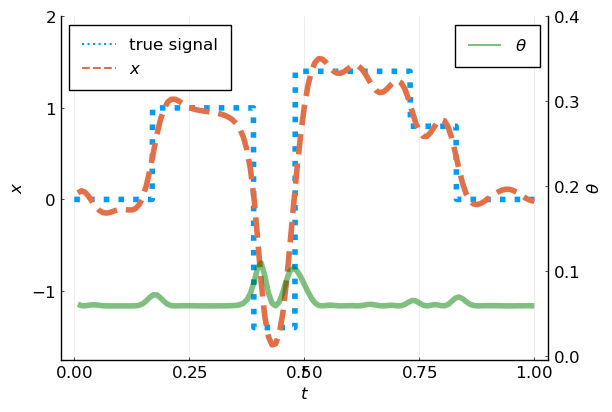

In [19]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
z_pullback = zeros(Float64,N)
x_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for n in 1:N 
    τ = τ_MAP[n]
    u = u_MAP[n]
    z_pullback[n], θ_pullback[n] = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

# Get the pullback values for x 
x_pullback = L \ z_pullback

# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_pullback; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_pullback; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-4e-3, 0.4],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_priorNormalized.pdf"
)
#PyPlot.savefig(output_filename)

## MAP estimation for model with $r=1/2$

### Initiate the model

In [20]:
# Select hyper-hyper-parameters 
model_nr = 2 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [21]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation 
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success

 * Candidate solution
    Final objective value:     1.251129e+02

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 8.43e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.23e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.71e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   161  (vs limit 600)
    Iterations:    13147
    f(x) calls:    42358
    ∇f(x) calls:   42358


In [22]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
z_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
x_MAP = L \ z_MAP

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_original.jld2" θ_MAP z_MAP x_MAP

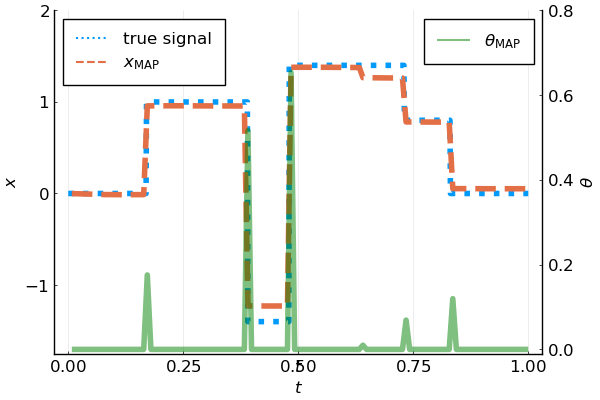

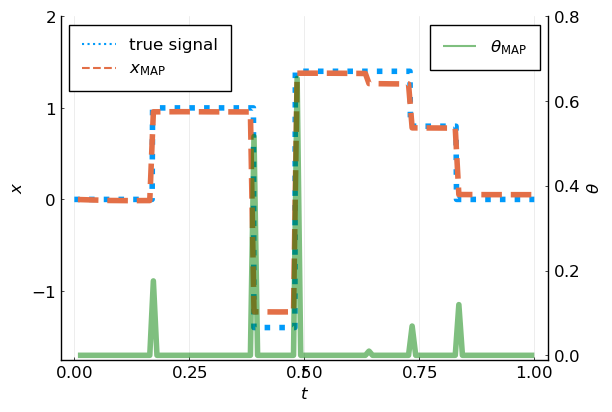

In [23]:
# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_MAP; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_MAP; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-1e-2, 0.8],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_original.pdf"
)
#PyPlot.savefig(output_filename)

### MAP estimate for the prior-normalized posterior

In [24]:
# Initial guess for the optimization (τ and u)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success

 * Candidate solution
    Final objective value:     1.842259e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.73e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.35e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 8.62e-08 ≰ 1.0e-08

 * Work counters
    Seconds run:   55  (vs limit 600)
    Iterations:    602
    f(x) calls:    1797
    ∇f(x) calls:   1797


In [25]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
u_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP u_MAP

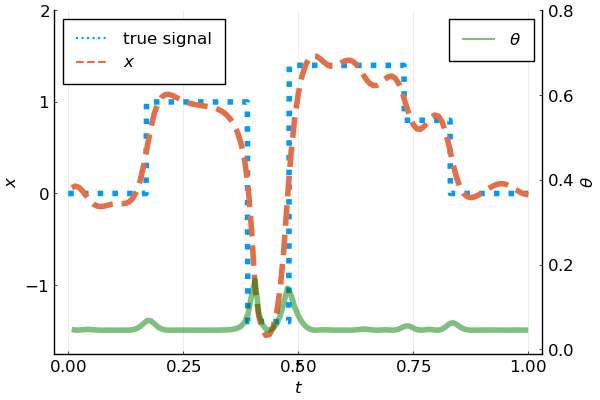

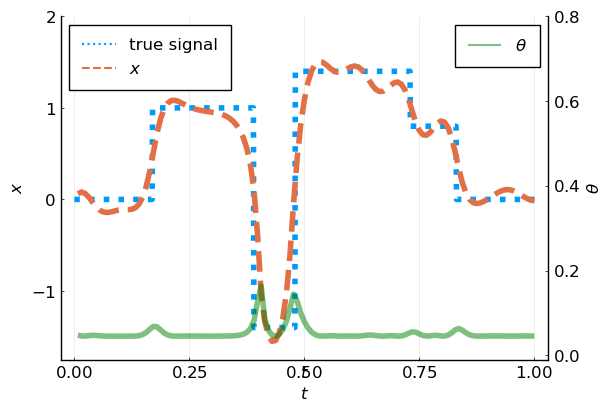

In [26]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
z_pullback = zeros(Float64,N)
x_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for n in 1:N 
    τ = τ_MAP[n]
    u = u_MAP[n]
    z_pullback[n], θ_pullback[n] = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

# Get the pullback values for x 
x_pullback = L \ z_pullback


# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_pullback; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_pullback; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-1e-2, 0.8],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_priorNormalized.pdf"
)
#PyPlot.savefig(output_filename)

## MAP estimation for model with $r=-1/2$

### Initiate the models

In [27]:
# Select hyper-hyper-parameters 
model_nr = 3 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [28]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation  
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success

 * Candidate solution
    Final objective value:     -2.431681e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.40e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.57e-12 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.07e-06 ≰ 1.0e-08

 * Work counters
    Seconds run:   578  (vs limit 600)
    Iterations:    38534
    f(x) calls:    115965
    ∇f(x) calls:   115965


In [29]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
z_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
x_MAP = L \ z_MAP

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_original.jld2" θ_MAP z_MAP x_MAP

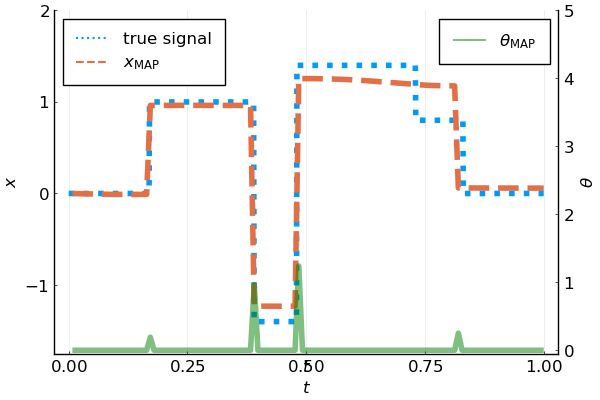

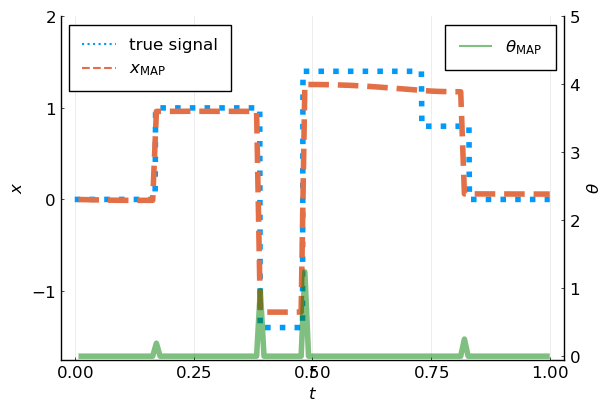

In [30]:
# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_MAP; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_MAP; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-5e-2, 5],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_original.pdf"
)
#PyPlot.savefig(output_filename)

### MAP estimate for the prior-normalized posterior

In [31]:
# Initial guess for the optimization (τ and u)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: success (objective increased between iterations)

 * Candidate solution
    Final objective value:     3.664723e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.17e-11 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.43e-11 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.11e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.94e-15 ≰ 0.0e+00
    |g(x)|                 = 6.17e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   78  (vs limit 600)
    Iterations:    859
    f(x) calls:    2486
    ∇f(x) calls:   2486


In [32]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
u_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP u_MAP

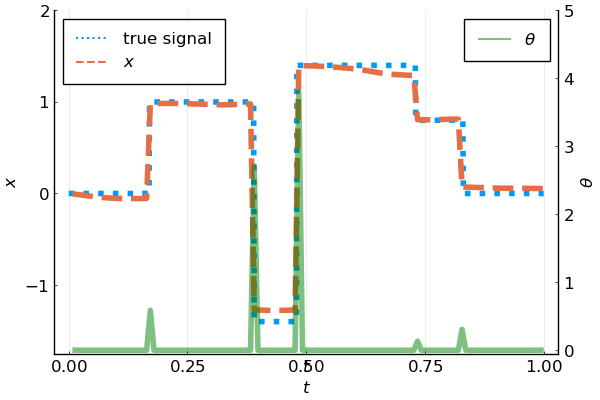

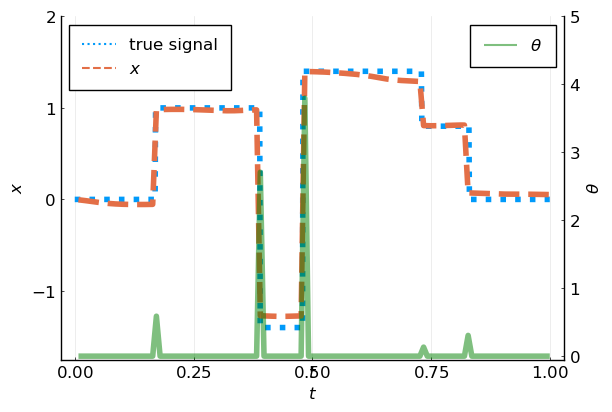

In [33]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
z_pullback = zeros(Float64,N)
x_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for n in 1:N 
    τ = τ_MAP[n]
    u = u_MAP[n]
    z_pullback[n], θ_pullback[n] = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

# Get the pullback values for x 
x_pullback = L \ z_pullback

# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_pullback; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_pullback; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-5e-2, 5],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_priorNormalized.pdf"
)
#PyPlot.savefig(output_filename)

## MAP estimation for model with $r=-1$

### Initiate the models

In [34]:
# Select hyper-hyper-parameters 
model_nr = 4 

# Select hyper-hyper-parameters 
r = r_range[model_nr] # power parameter 
β = β_range[model_nr] # shape parameter 
ϑ = ϑ_range[model_nr] # scale parameter

# We use ApproxFun.jl to build a Chebychev approximation of the function gammainvccdf(β, 1, ⋅) 
interval = -5..5
# Create an array of functions
if r > 0 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5*erfc(τ/sqrt(2)) ), interval)
else 
    Γinvccdfcheb = Fun(τ -> gammainvccdf(β, 1, 0.5 + 0.5*erf(τ/sqrt(2)) ), interval)
end

# Change definition and define negative log-PDF
neg_logpdf_original(ξ) = -logpdf_original(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ
)

# Change definition and define negative log-PDF
neg_logpdf_priorNormalized(ξ) = -logpdf_priorNormalized(
    ξ[1:2:end-1], ξ[2:2:end]; 
    F, y, r, β, ϑ, Φ=Γinvccdfcheb
)

neg_logpdf_priorNormalized (generic function with 1 method)

### MAP estimate for the original posterior

In [35]:
# Initial guess for the optimization (θ and z)
initial_guess = repeat([1e-3; 0.0], N, 1)

# MAP estimation  
MAP_original = optimize(
    neg_logpdf_original, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: failure (exceeded time limit of 600.0)

 * Candidate solution
    Final objective value:     -2.739365e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.37e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.76e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.02e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.37e-12 ≰ 0.0e+00
    |g(x)|                 = 2.16e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   600  (vs limit 600)
    Iterations:    52104
    f(x) calls:    158735
    ∇f(x) calls:   158735


In [36]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_original)
θ_MAP = MAP_values[1:2:end-1]
z_MAP = MAP_values[2:2:end] 

# Get the signal values from the increments 
x_MAP = L \ z_MAP

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_original.jld2" θ_MAP z_MAP x_MAP

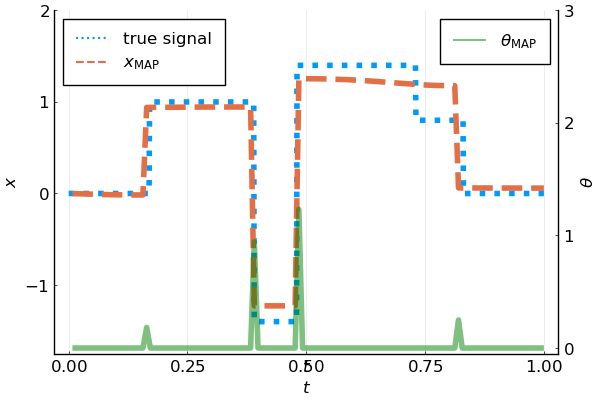

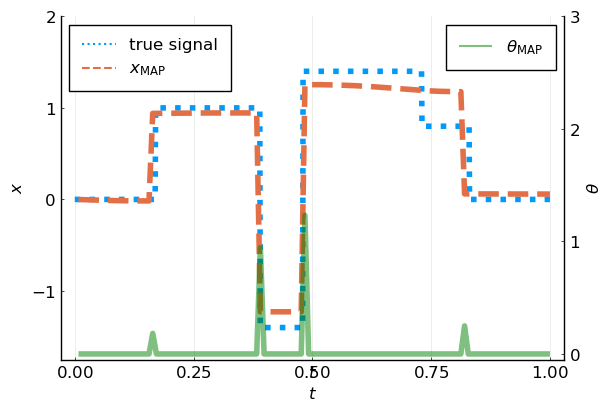

In [37]:
# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_MAP; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_MAP; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-5e-2, 3.0],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_original.pdf"
)
#PyPlot.savefig(output_filename)

### MAP estimate for the prior-normalized posterior

In [38]:
# Initial guess for the optimization (τ and u)
initial_guess = repeat([0.0; 0.0], N, 1)

# MAP estimation  
MAP_priorNormalized = optimize(
    neg_logpdf_priorNormalized, initial_guess, LBFGS(), 
    Optim.Options(iterations = 100_000, time_limit = 600.0)
)

 * Status: failure (line search failed)

 * Candidate solution
    Final objective value:     7.044776e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.82e-12 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.64e-13 ≰ 0.0e+00
    |f(x) - f(x')|         = 8.21e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.17e-13 ≰ 0.0e+00
    |g(x)|                 = 2.47e-07 ≰ 1.0e-08

 * Work counters
    Seconds run:   400  (vs limit 600)
    Iterations:    4399
    f(x) calls:    12653
    ∇f(x) calls:   12653


In [39]:
# Extract the numerical values 
MAP_values = Optim.minimizer(MAP_priorNormalized)
τ_MAP = MAP_values[1:2:end-1]
u_MAP = MAP_values[2:2:end] 

# Save the vectors to a file
@save "data/deblurring_model$(model_nr)_MAP_priorNormalized.jld2" τ_MAP u_MAP

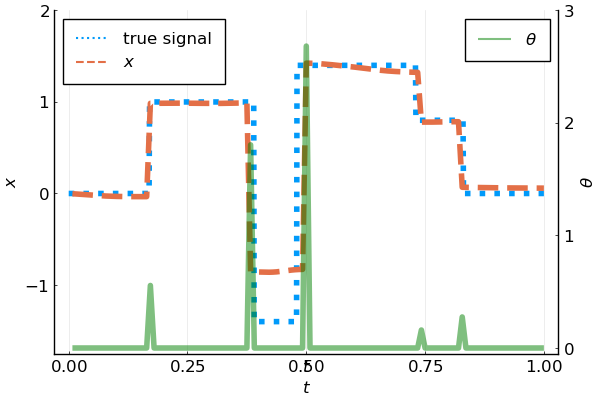

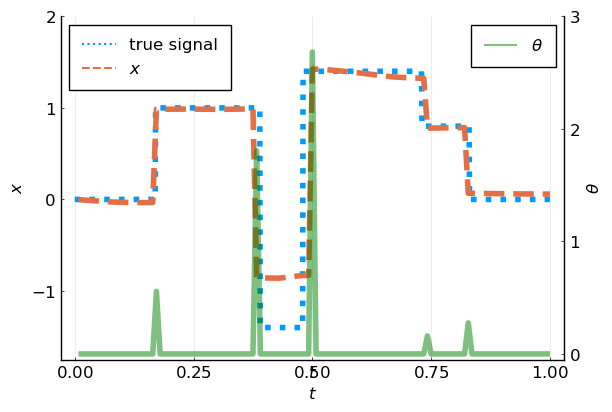

In [40]:
# Compute the pullback of the MAP estimate for (τ,u)

# Initiate the vectors 
θ_pullback = zeros(Float64,N)
z_pullback = zeros(Float64,N)
x_pullback = zeros(Float64,N)

# Get the pullback values for z and θ
for n in 1:N 
    τ = τ_MAP[n]
    u = u_MAP[n]
    z_pullback[n], θ_pullback[n] = priorNormalizing_KR_inv( u, τ; r, β, ϑ, Φ=Γinvccdfcheb )
end

# Get the pullback values for x 
x_pullback = L \ z_pullback

# Illustrate the MAP estimate of the target posterior
pyplot() 

# Initiate plot 
p = Plots.plot() 
p_twin = twinx(p)

# Create the plot 
Plots.plot!( p, 
    t_range_aux, signal_values; 
    label="true signal", 
    lw=4, ls=:dot 
)
# Add MAP estimate for x 
Plots.plot!( p, 
    t_coarse, x_pullback; 
    label=L"x_{\rm MAP}", 
    lw=4, ls=:dash
)

# Add MAP estimate for θ  
Plots.plot!( p_twin,  
    t_coarse, θ_pullback; 
    label=L"\theta_{\rm MAP}", 
    lw=4, ls=:solid, color=:green, alpha=0.5
)

# Make some cosmetic changes to the plot 
Plots.plot!( p,
    ylim = [-1.75, 2.0],
    xlabel=L"t", ylabel=L"x", legend=:topleft,
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Make some cosmetic changes to the plot 
Plots.plot!( p_twin, 
    ylim = [-5e-2, 3.0],
    ylabel=L"\theta", legend=:topright,  
    tickfontsize=12, labelfontsize=12, legendfontsize=12 # font sizes 
)

# Display the plot
display(p)

# Save the plot 
script_directory = @__DIR__  # Gets the directory of the current script
output_filename = joinpath(
    script_directory, 
    "figures", 
    "deblurring_model$(model_nr)_MAP_priorNormalized.pdf"
)
#PyPlot.savefig(output_filename)